In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score



In [2]:
%store -r wids

# Clustering
use age, bmi, pre_icu_los_days, d1_heartrate_min, apache_4a_hospital_death_prob, apache_4a_icu_death_prob

### Use LGBM to predict missing values in each column

In [3]:
df = wids[['age', 'bmi', 'pre_icu_los_days', 'd1_heartrate_min', 
           'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']]

In [4]:
lgb_impute = LGBMRegressor(boosting_type ='gbdt', n_estimators = 200, 
                           learning_rate = .05, max_depth = 7, 
                           num_leaves = 200,
                           objective ='regression')

In [5]:
df_result = dict.fromkeys(['age', 'bmi', 'd1_heartrate_min', 
           'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'])

In [6]:
for idx, i in enumerate(list(df_result.keys())):
    X_holdout = df[df[i].isna()].drop(i, axis=1)
    
    X = df[df[i].notna()].drop(i, axis=1)
    y = df.loc[df[i].notna(), i]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # Train model
    print('-------- training model on column {}-----------'.format(i))
    lgb_impute.fit(X_train, y_train)
    
    # Predict on test and train
    print('-------- predicting on column {}-----------'.format(i))
    y_pred = lgb_impute.predict(X_test)
    y_train_pred = lgb_impute.predict(X_train)
    
    # Evaluation
    print('-------- Evaluating prediction on column {}-----------'.format(i))
    print('The rmse of test prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    print('The rmse of train prediction is:', mean_squared_error(y_train, y_train_pred) ** 0.5)
    print('The 4-fold CV rmse is:',
         -cross_val_score(lgb_impute, X_train, y_train, cv=4, scoring = 'neg_root_mean_squared_error'))
    
    
    
    # Predict on holdout 
    print('-------- predicting holdout on column {}-----------'.format(i))
    df_result[i] = lgb_impute.predict(X_holdout)

-------- training model on column age-----------
-------- predicting on column age-----------
-------- Evaluating prediction on column age-----------
The rmse of test prediction is: 13.588360727165972
The rmse of train prediction is: 12.991279178200884
The 4-fold CV rmse is: [13.60428968 13.74940312 13.53967934 13.60027459]
-------- predicting holdout on column age-----------
-------- training model on column bmi-----------
-------- predicting on column bmi-----------
-------- Evaluating prediction on column bmi-----------
The rmse of test prediction is: 8.00640401653372
The rmse of train prediction is: 7.830414986196104
The 4-fold CV rmse is: [8.11142866 8.16800035 8.11508682 8.10037072]
-------- predicting holdout on column bmi-----------
-------- training model on column d1_heartrate_min-----------
-------- predicting on column d1_heartrate_min-----------
-------- Evaluating prediction on column d1_heartrate_min-----------
The rmse of test prediction is: 16.97045534779196
The rmse o

In [7]:
df.describe()

,age,bmi,pre_icu_los_days,d1_heartrate_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
count,87485.000000,88284.000000,91713.000000,91568.000000,83766.000000,83766.000000
mean,62.309516,29.185818,0.835766,70.321848,0.086787,0.043955
std,16.775119,8.275142,2.487756,17.115903,0.247569,0.217341
min,16.000000,14.844926,-24.947222,0.000000,-1.000000,-1.000000
25%,52.000000,23.641975,0.035417,60.000000,0.020000,0.010000
50%,65.000000,27.654655,0.138889,69.000000,0.050000,0.020000
75%,75.000000,32.930206,0.409028,81.000000,0.130000,0.060000
max,89.000000,67.814990,159.090972,175.000000,0.990000,0.970000


In [8]:
# Put missing values back to column
for i in list(df_result.keys()):
    df.loc[df[i].isna(), i] = df_result[i]

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.isna().sum()

age                              0
bmi                              0
pre_icu_los_days                 0
d1_heartrate_min                 0
apache_4a_hospital_death_prob    0
apache_4a_icu_death_prob         0
dtype: int64

### Form clusters
use DBSCAN

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [29]:
# Standardize 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

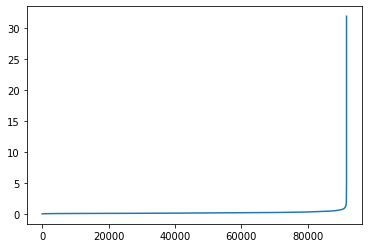

In [30]:
# Parameters Tuning
neigh = NearestNeighbors(n_neighbors=6)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
# Choose epsilon around 0.04. 

In [50]:
# Apply DBSCAN.
DB_cluster = DBSCAN(eps = 2, min_samples = 50).fit(df)
labels = DB_cluster.labels_

In [51]:
set(labels)

{-1, 0, 1, 2, 3, 4}

In [52]:
# Check hospital_death in each group
wids['DBSCAN_label'] = labels
wids.groupby('DBSCAN_label')['hospital_death'].mean()

DBSCAN_label
-1    0.096208
 0    0.069065
 1    0.000000
 2    0.140000
 3    0.051282
 4    0.041667
Name: hospital_death, dtype: float64

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


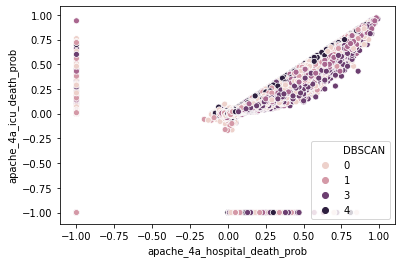

In [91]:
# Visualize DBSCAN cluster
import seaborn as sns

df['DBSCAN'] = labels
sns.scatterplot('apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', hue='DBSCAN', data=df)

Use KMeans

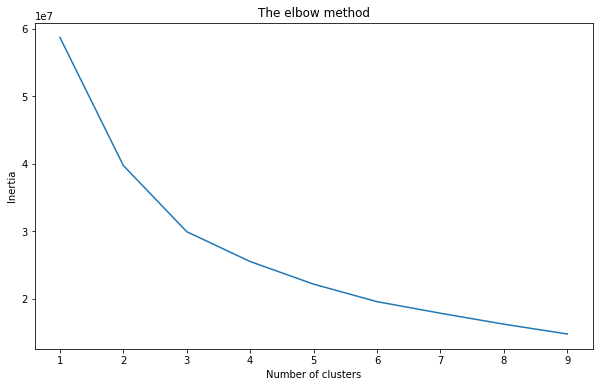

In [64]:
# Try KMeans
# Inertia plot to determine k
from sklearn.cluster import KMeans

inertia = []
x_axis=range(1,10)
for i in x_axis:
        model = KMeans(n_clusters = i, random_state = 4)
        model.fit(df)
        inertia.append(model.inertia_)
    
    
fig, ax = plt.subplots(figsize=(10,6))
    
ax.set_title('The elbow method')
ax.set_ylabel('Inertia')
ax.set_xlabel('Number of clusters')
plt.plot(x_axis, inertia)

In [72]:
# Predict KMeans cluster
model = KMeans(n_clusters=5, random_state=4)
labels = model.fit_predict(df)

In [83]:
wids['KMeans'] = labels
wids.groupby('KMeans')['apache_4a_icu_death_prob'].median()

KMeans
0    0.03
1    0.01
2    0.03
3    0.03
4    0.01
Name: apache_4a_icu_death_prob, dtype: float64

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


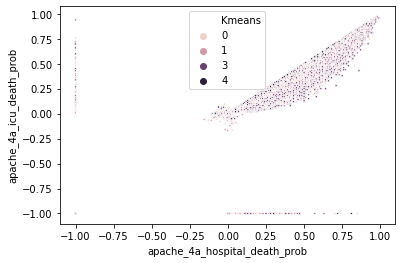

In [96]:
# Visualize KMeans cluster
df['Kmeans'] = wids['KMeans']
sns.scatterplot('apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', 
                hue='Kmeans', data=df, 
               s=5)

Use TSNE

In [84]:
# Use TSNE
from sklearn.manifold import TSNE
model = TSNE(learning_rate = 80)
tsne_features = model.fit_transform(df_scaled)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

In [87]:
pd.DataFrame(tsne_features).to_csv('tsne_features.csv', index=False)

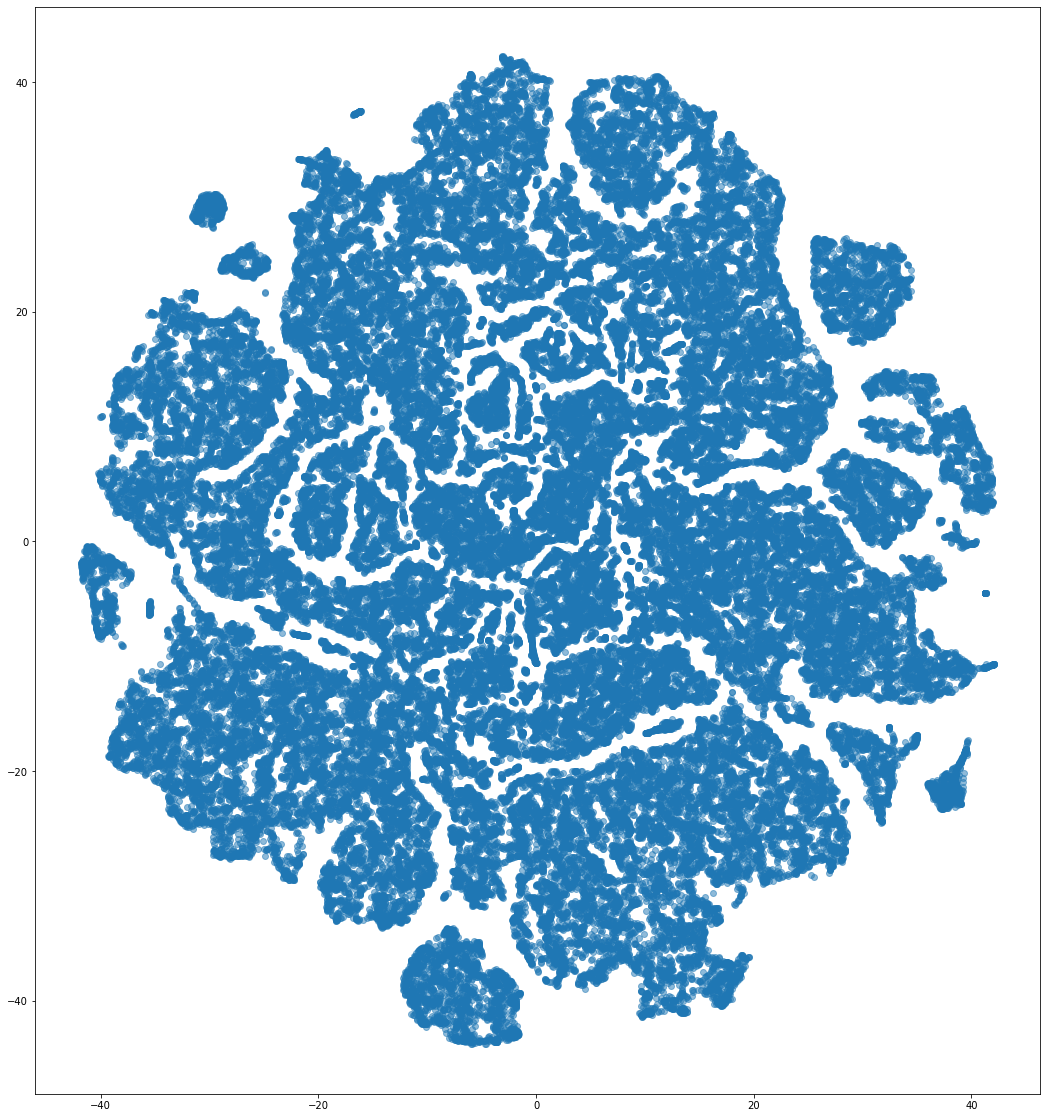

In [90]:
# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]


plt.figure(figsize=(18,20))
# Scatter plot
plt.scatter(xs, ys, alpha=0.5)
plt.savefig('tsne.png')

In [ ]:
plt.figure(figsize=(18,20))
# Scatter plot
plt.scatter(xs, ys, alpha=0.5)

# Annotate the points
for x, y, company in zip(xs, ys, delta.index):
    plt.annotate(company, (x, y), fontsize=10, alpha=0.75)

In [98]:
wids[['DBSCAN_label', 'KMeans']].to_csv('labels_clustering.csv')